In [1]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray'):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    plt.show()

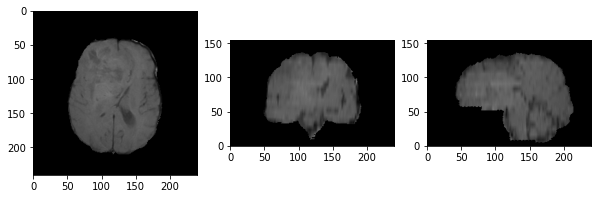

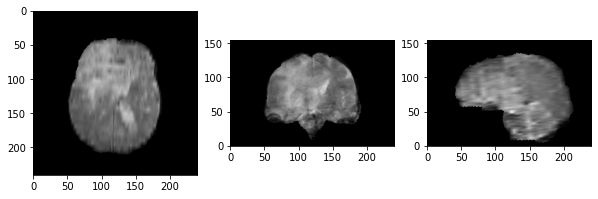

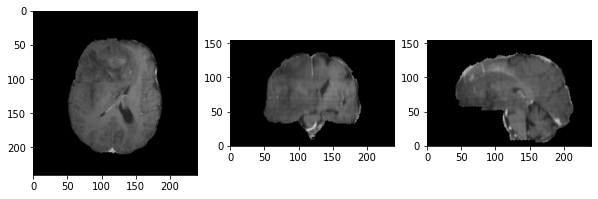

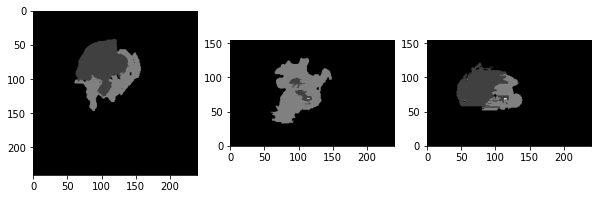

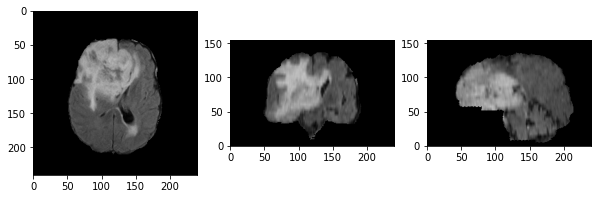

(240, 240, 155)
(1.0, 1.0, 1.0)


In [3]:
# Brats data path
data_dir_name = '/vol/bitbucket/sc5316/Brats17TrainingData/LGG/'
samples = os.listdir(data_dir_name)

# Image
image_filename = data_dir_name + samples[3] + '/' + samples[3] + '_t1.nii.gz'
img = sitk.ReadImage(image_filename)

image2_filename = data_dir_name + samples[3] + '/' + samples[3] + '_t2.nii.gz'
img2 = sitk.ReadImage(image2_filename)

image3_filename = data_dir_name + samples[3] + '/' + samples[3] + '_t1ce.nii.gz'
img3 = sitk.ReadImage(image3_filename)

image4_filename = data_dir_name + samples[3] + '/' + samples[3] + '_seg.nii.gz'
img4 = sitk.ReadImage(image4_filename)

image5_filename = data_dir_name + samples[3] + '/' + samples[3] + '_flair.nii.gz'
img5 = sitk.ReadImage(image5_filename)

display_image(img)
display_image(img2)
display_image(img3)
display_image(img4)
display_image(img5)

print(img4.GetSize())
print(img4.GetSpacing())

In [4]:
def zero_mean_unit_var(image):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    mean = np.mean(img_array[img_array>0])
    std = np.std(img_array[img_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
#         img_array[img_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing), -1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    if is_label:
        resample.SetDefaultPixelValue(0)
    else:
        resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            #pre=processing
            img = zero_mean_unit_var(img)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)

        return {'img': image, 'seg': seg}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print('Device: ' + str(device))

Device: cuda


In [57]:
rnd_seed = 42 #fixed random seed

img_size = [88,88,88]
img_spacing = [2.2,2.2,2.2]

num_epochs = 150
learning_rate = 0.001
batch_size = 8
val_interval = 3

num_classes = 5

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [49]:
files_seg_img = [data_dir_name + s + '/' + s + '_t1.nii.gz' for s in samples]
files_seg_seg = [data_dir_name + s + '/' + s + '_seg.nii.gz' for s in samples]
# Load training data
dataset_train = ImageSegmentationDataset(files_seg_img[:1], files_seg_seg[:1], img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

# dataset_val = ImageSegmentationDataset(files_seg_img[55:65], files_seg_seg[55:65], img_spacing, img_size)
# dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

# dataset_test = ImageSegmentationDataset(files_seg_img[65:70], files_seg_seg[65:70], img_spacing, img_size)
# dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Image: Brats17_TCIA_299_1_t1.nii.gz


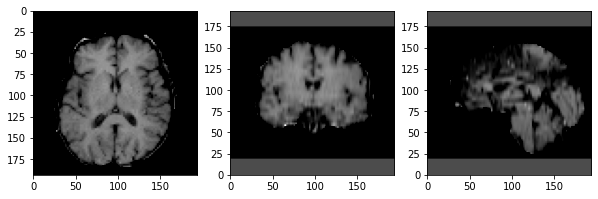

Segmentation


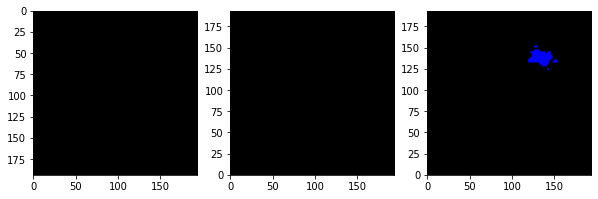

(88, 88, 88)


In [50]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=1)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
# display_image(sample['seg'], window=5, level=1)
print(sample['img'].GetSize())

In [61]:
#Downsampling component of the U-Net
class UnetDown(nn.Module):

    def __init__(self, in_channels,out_channels):
        super(UnetDown, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3,padding=1)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.pool  = nn.MaxPool3d(2)
        self.dropout = nn.Dropout3d(p=0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.batch_norm(x))
        x = self.dropout(x)
        x_downsample = self.pool(x)
        return x, x_downsample



#Upsampling of the U-Net
class UnetUp(nn.Module):

    def __init__(self, in_channels):
        super(UnetUp, self).__init__()
        self.upconv = nn.ConvTranspose3d(in_channels, in_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv3d(2 * in_channels, int(in_channels / 2), kernel_size=3,padding=1)
        self.batch_norm = nn.BatchNorm3d(int(in_channels/2))
        self.dropout = nn.Dropout3d(p=0.5)
  
    def forward(self, x_up, x_down):
        x_up = self.upconv(x_up)
        concat_fm = torch.cat((x_up, x_down), 1)
        x = self.conv1(concat_fm)
        x = F.relu(self.batch_norm(x))
        x = self.dropout(x)
        return x

class Unet(nn.Module):
  
    def __init__(self,in_channels, out_channels, num_classes):
        super(Unet,self).__init__()
        self.encode1 = UnetDown(in_channels, out_channels)
        self.encode2 = UnetDown(out_channels, 2 * out_channels)
        self.conv1 = nn.Conv3d(2 * out_channels, 2 * out_channels, kernel_size=3, padding=1)
        self.decode1 = UnetUp(2 * out_channels)
        self.decode2 = UnetUp(out_channels)
        self.out_conv = nn.Conv3d(int(out_channels/2),num_classes,kernel_size=3, padding=1)


    def forward(self, x):
        enc1 = self.encode1(x)
        enc2 = self.encode2(enc1[1])
        x1 = self.conv1(enc2[1])
        dec1 = self.decode1(x1,enc2[0])
        dec2 = self.decode2(dec1,enc1[0])
        x_out = self.out_conv(dec2)
        x_out = F.softmax(x_out, dim=1)
        return x_out

# class Unet(nn.Module):
  
#     def __init__(self,in_channels, out_channels, num_classes):
#         super(Unet,self).__init__()
#         self.encode1 = UnetDown(in_channels, out_channels)
#         self.encode2 = UnetDown(out_channels, 2 * out_channels)
#         self.encode3 = UnetDown(2 * out_channels, 4 * out_channels)
#         self.conv1 = nn.Conv3d(4 * out_channels, 4 * out_channels, kernel_size=3, padding=1)
#         self.decode1 = UnetUp(4 * out_channels)
#         self.decode2 = UnetUp(2 * out_channels)
#         self.decode3 = UnetUp(out_channels)
#         self.out_conv = nn.Conv3d(int(out_channels/2),num_classes,kernel_size=3, padding=1)


#     def forward(self, x):
#         enc1 = self.encode1(x)
#         enc2 = self.encode2(enc1[1])
#         enc3 = self.encode3(enc2[1])
#         x1 = self.conv1(enc3[1])
#         dec1 = self.decode1(x1,enc3[0])
#         dec2 = self.decode2(dec1,enc2[0])
#         dec3 = self.decode3(dec2,enc1[0])
#         x_out = self.out_conv(dec3)
#         x_out = F.softmax(x_out, dim=1)
#         return x_out

Let's use 5 GPUs!
START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.970018
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.000001


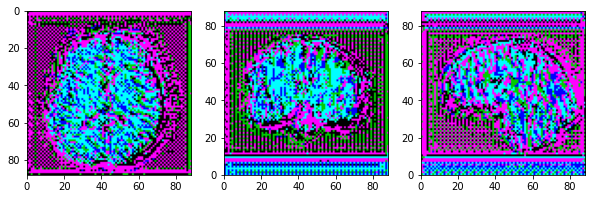

Traceback (most recent call last):
Traceback (most recent call last):
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (mo

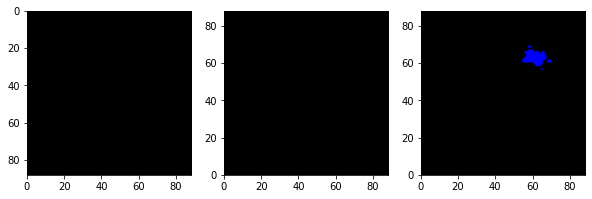

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.967442
+ TRAINING 	Epoch: 3 	Loss: 0.966081
--------------------------------------------------
+ VALIDATE 	Epoch: 3 	Loss: 0.000001


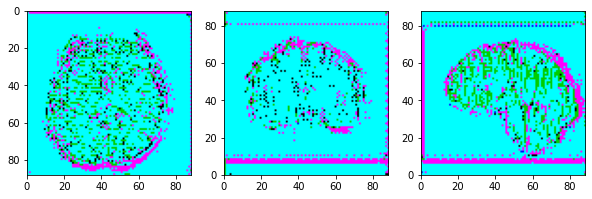

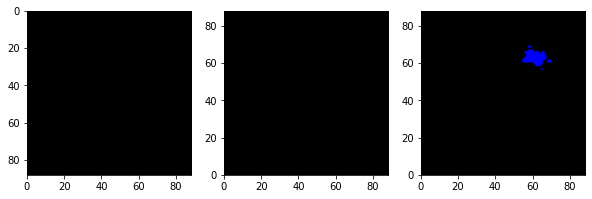

--------------------------------------------------
+ TRAINING 	Epoch: 4 	Loss: 0.970179
+ TRAINING 	Epoch: 5 	Loss: 0.964866
+ TRAINING 	Epoch: 6 	Loss: 0.965806
--------------------------------------------------
+ VALIDATE 	Epoch: 6 	Loss: 0.000001


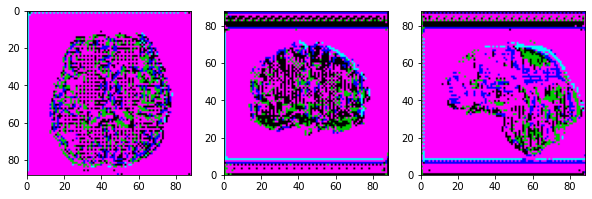

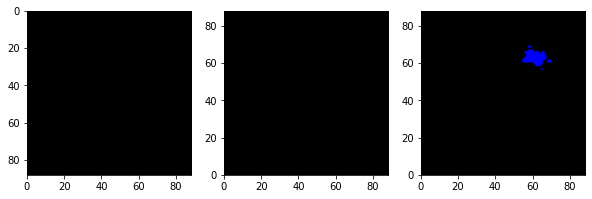

--------------------------------------------------
+ TRAINING 	Epoch: 7 	Loss: 0.967265
+ TRAINING 	Epoch: 8 	Loss: 0.968508
+ TRAINING 	Epoch: 9 	Loss: 0.956581
--------------------------------------------------
+ VALIDATE 	Epoch: 9 	Loss: 0.000001


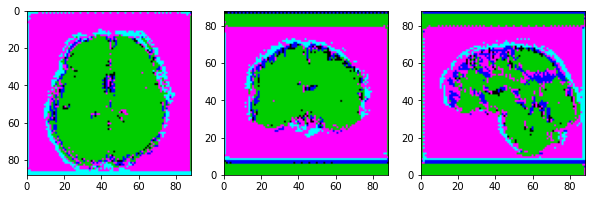

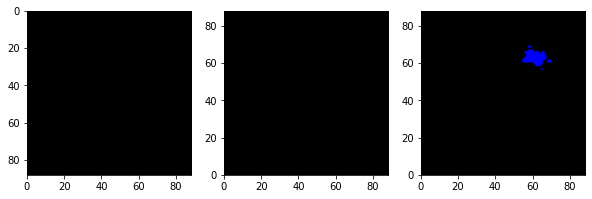

--------------------------------------------------
+ TRAINING 	Epoch: 10 	Loss: 0.960581
+ TRAINING 	Epoch: 11 	Loss: 0.961605
+ TRAINING 	Epoch: 12 	Loss: 0.956295
--------------------------------------------------
+ VALIDATE 	Epoch: 12 	Loss: 0.000001


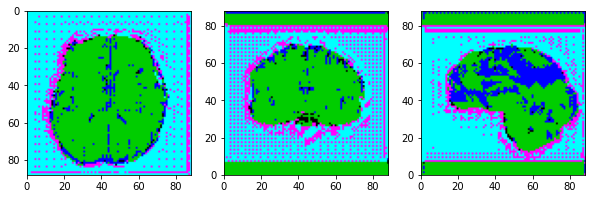

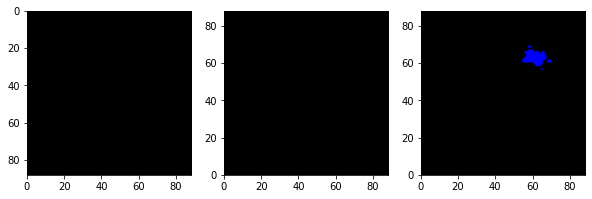

--------------------------------------------------
+ TRAINING 	Epoch: 13 	Loss: 0.968402
+ TRAINING 	Epoch: 14 	Loss: 0.953246
+ TRAINING 	Epoch: 15 	Loss: 0.963455
--------------------------------------------------
+ VALIDATE 	Epoch: 15 	Loss: 0.000001


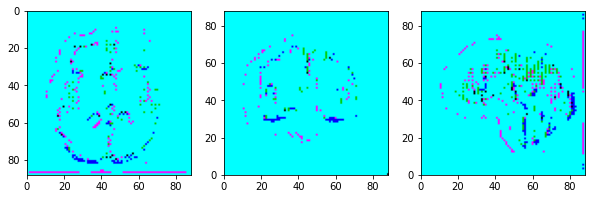

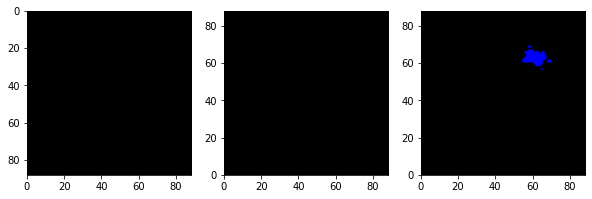

--------------------------------------------------
+ TRAINING 	Epoch: 16 	Loss: 0.951375
+ TRAINING 	Epoch: 17 	Loss: 0.953425
+ TRAINING 	Epoch: 18 	Loss: 0.944262
--------------------------------------------------
+ VALIDATE 	Epoch: 18 	Loss: 0.000001


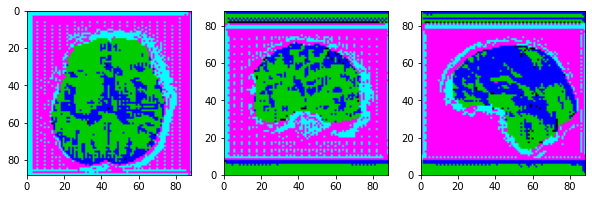

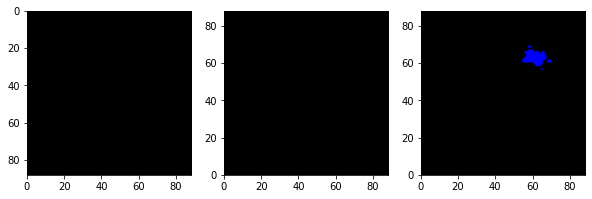

--------------------------------------------------
+ TRAINING 	Epoch: 19 	Loss: 0.956578
+ TRAINING 	Epoch: 20 	Loss: 0.953308
+ TRAINING 	Epoch: 21 	Loss: 0.938817
--------------------------------------------------
+ VALIDATE 	Epoch: 21 	Loss: 0.000001


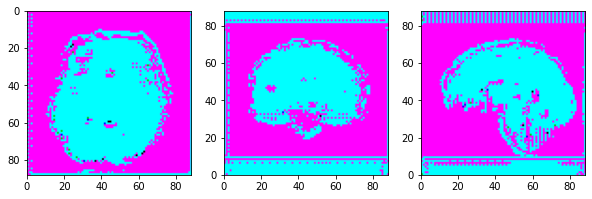

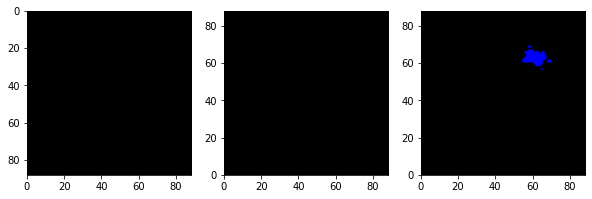

--------------------------------------------------
+ TRAINING 	Epoch: 22 	Loss: 0.929420
+ TRAINING 	Epoch: 23 	Loss: 0.947877
+ TRAINING 	Epoch: 24 	Loss: 0.959310
--------------------------------------------------
+ VALIDATE 	Epoch: 24 	Loss: 0.000001


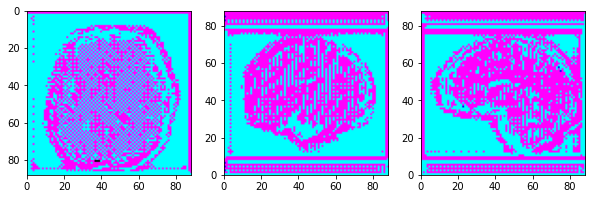

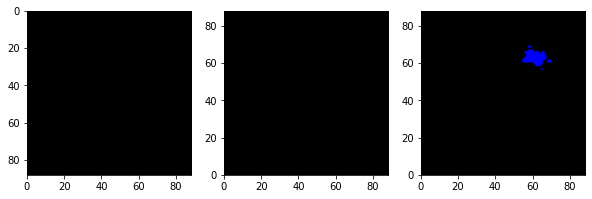

--------------------------------------------------
+ TRAINING 	Epoch: 25 	Loss: 0.939893
+ TRAINING 	Epoch: 26 	Loss: 0.922388
+ TRAINING 	Epoch: 27 	Loss: 0.927923
--------------------------------------------------
+ VALIDATE 	Epoch: 27 	Loss: 0.000001


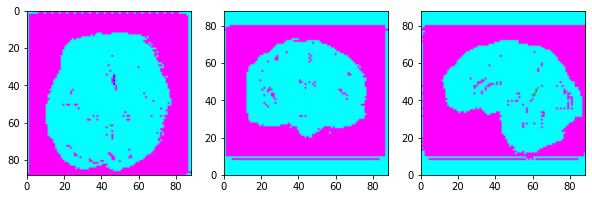

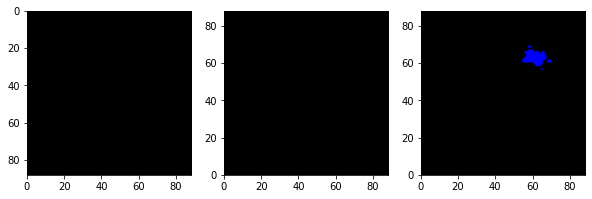

--------------------------------------------------
+ TRAINING 	Epoch: 28 	Loss: 0.914425
+ TRAINING 	Epoch: 29 	Loss: 0.901927
+ TRAINING 	Epoch: 30 	Loss: 0.937022
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.000001


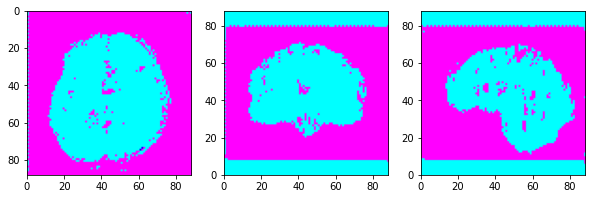

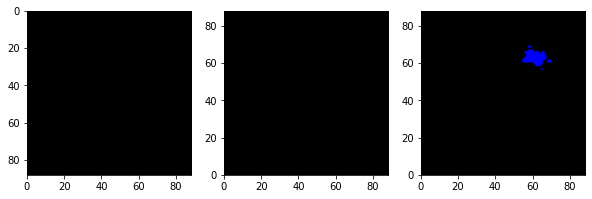

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.939829
+ TRAINING 	Epoch: 32 	Loss: 0.921947
+ TRAINING 	Epoch: 33 	Loss: 0.916781
--------------------------------------------------
+ VALIDATE 	Epoch: 33 	Loss: 0.000001


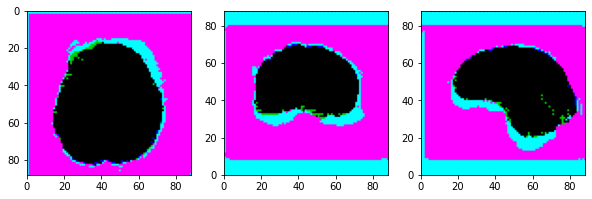

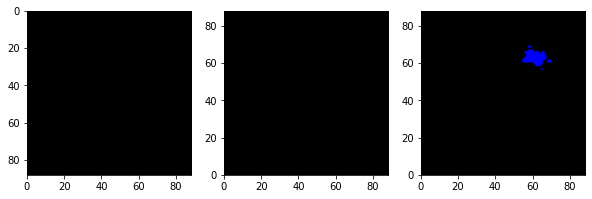

--------------------------------------------------
+ TRAINING 	Epoch: 34 	Loss: 0.971534
+ TRAINING 	Epoch: 35 	Loss: 0.936687
+ TRAINING 	Epoch: 36 	Loss: 0.886707
--------------------------------------------------
+ VALIDATE 	Epoch: 36 	Loss: 0.000001


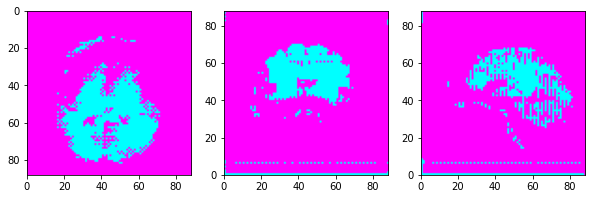

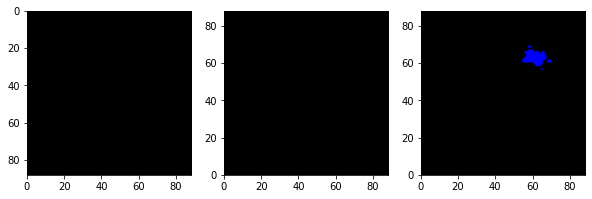

--------------------------------------------------
+ TRAINING 	Epoch: 37 	Loss: 0.896969
+ TRAINING 	Epoch: 38 	Loss: 0.905352
+ TRAINING 	Epoch: 39 	Loss: 0.899636
--------------------------------------------------
+ VALIDATE 	Epoch: 39 	Loss: 0.000001


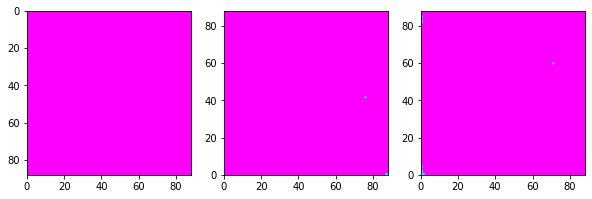

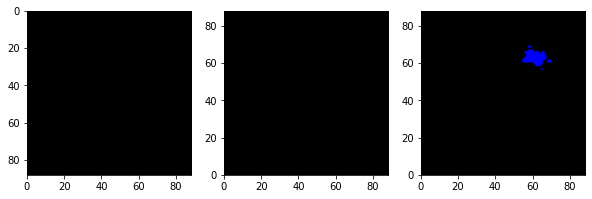

--------------------------------------------------
+ TRAINING 	Epoch: 40 	Loss: 0.893484
+ TRAINING 	Epoch: 41 	Loss: 0.956001
+ TRAINING 	Epoch: 42 	Loss: 0.903009
--------------------------------------------------
+ VALIDATE 	Epoch: 42 	Loss: 0.000001


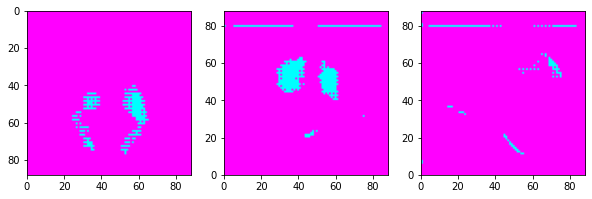

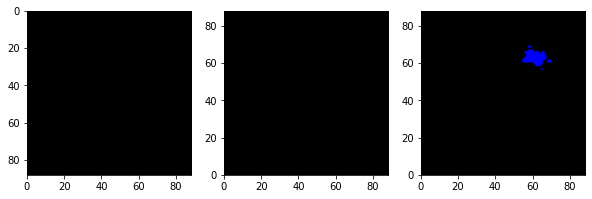

--------------------------------------------------
+ TRAINING 	Epoch: 43 	Loss: 0.923848
+ TRAINING 	Epoch: 44 	Loss: 0.918563
+ TRAINING 	Epoch: 45 	Loss: 0.880183
--------------------------------------------------
+ VALIDATE 	Epoch: 45 	Loss: 0.000001


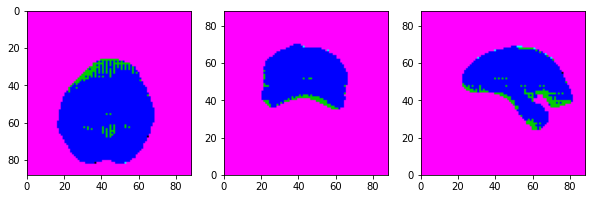

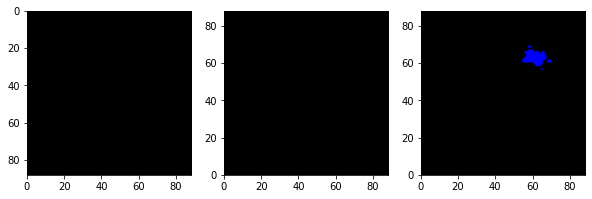

--------------------------------------------------
+ TRAINING 	Epoch: 46 	Loss: 0.880825
+ TRAINING 	Epoch: 47 	Loss: 0.882869
+ TRAINING 	Epoch: 48 	Loss: 0.887123
--------------------------------------------------
+ VALIDATE 	Epoch: 48 	Loss: 0.000001


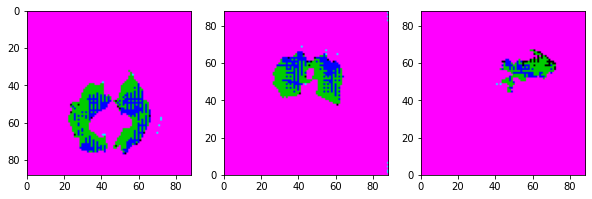

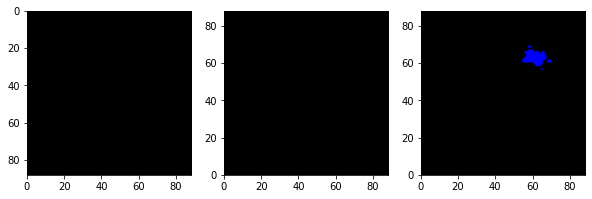

--------------------------------------------------
+ TRAINING 	Epoch: 49 	Loss: 0.870481
+ TRAINING 	Epoch: 50 	Loss: 0.929768
+ TRAINING 	Epoch: 51 	Loss: 0.896175
--------------------------------------------------
+ VALIDATE 	Epoch: 51 	Loss: 0.000001


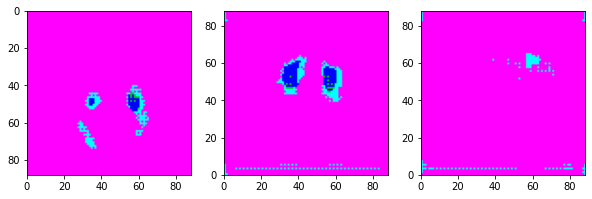

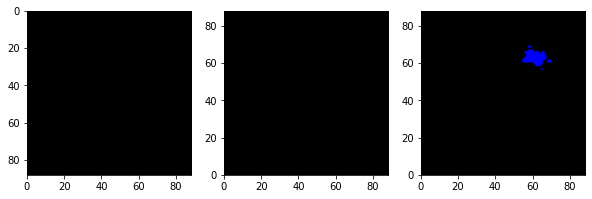

--------------------------------------------------
+ TRAINING 	Epoch: 52 	Loss: 0.911184
+ TRAINING 	Epoch: 53 	Loss: 0.886674
+ TRAINING 	Epoch: 54 	Loss: 0.871827
--------------------------------------------------
+ VALIDATE 	Epoch: 54 	Loss: 0.000001


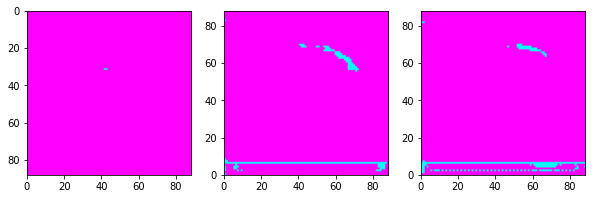

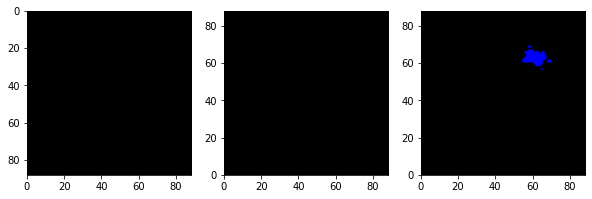

--------------------------------------------------
+ TRAINING 	Epoch: 55 	Loss: 0.856218
+ TRAINING 	Epoch: 56 	Loss: 0.900048
+ TRAINING 	Epoch: 57 	Loss: 0.905241
--------------------------------------------------
+ VALIDATE 	Epoch: 57 	Loss: 0.000001


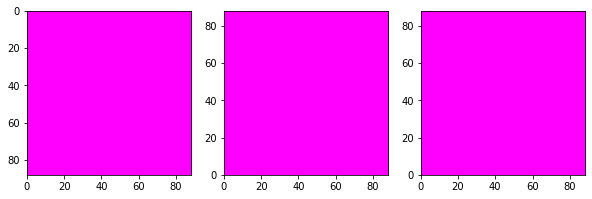

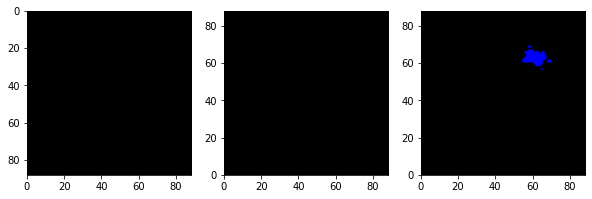

--------------------------------------------------
+ TRAINING 	Epoch: 58 	Loss: 0.892001
+ TRAINING 	Epoch: 59 	Loss: 0.855247
+ TRAINING 	Epoch: 60 	Loss: 0.932967
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.000001


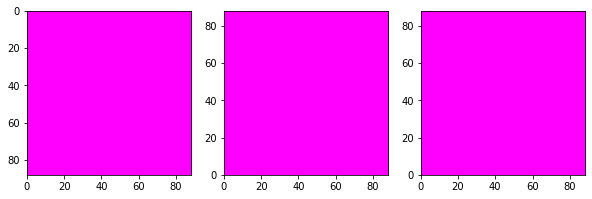

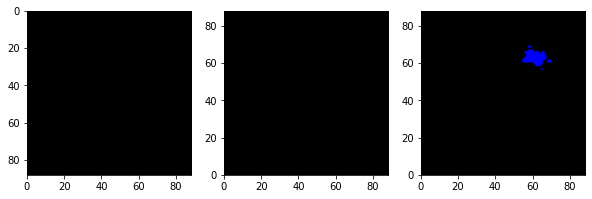

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.837396
+ TRAINING 	Epoch: 62 	Loss: 0.843259
+ TRAINING 	Epoch: 63 	Loss: 0.806118
--------------------------------------------------
+ VALIDATE 	Epoch: 63 	Loss: 0.000001


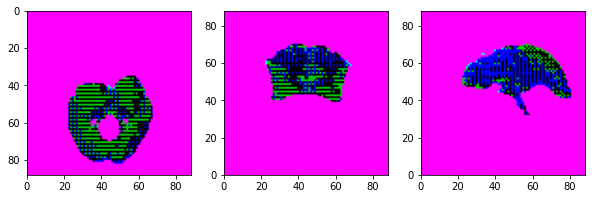

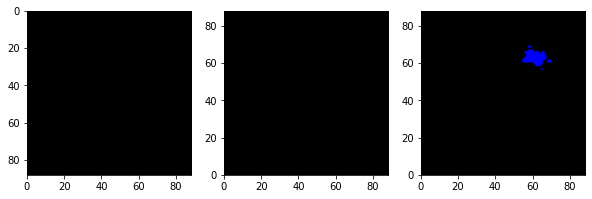

--------------------------------------------------
+ TRAINING 	Epoch: 64 	Loss: 0.922664
+ TRAINING 	Epoch: 65 	Loss: 0.870229
+ TRAINING 	Epoch: 66 	Loss: 0.850970
--------------------------------------------------
+ VALIDATE 	Epoch: 66 	Loss: 0.000001


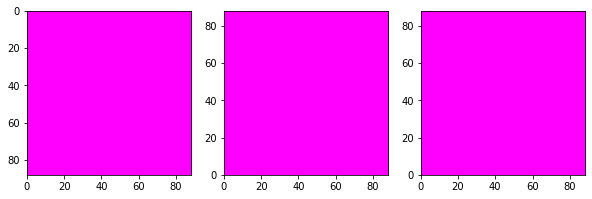

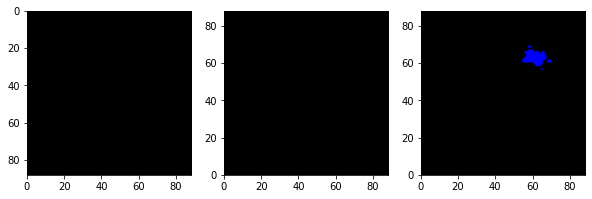

--------------------------------------------------
+ TRAINING 	Epoch: 67 	Loss: 0.869681
+ TRAINING 	Epoch: 68 	Loss: 0.954458
+ TRAINING 	Epoch: 69 	Loss: 0.930510
--------------------------------------------------
+ VALIDATE 	Epoch: 69 	Loss: 0.000001


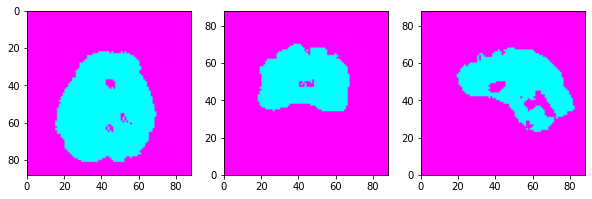

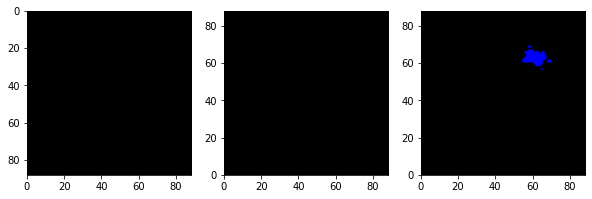

--------------------------------------------------
+ TRAINING 	Epoch: 70 	Loss: 0.869980
+ TRAINING 	Epoch: 71 	Loss: 0.898220
+ TRAINING 	Epoch: 72 	Loss: 0.883635
--------------------------------------------------
+ VALIDATE 	Epoch: 72 	Loss: 0.000001


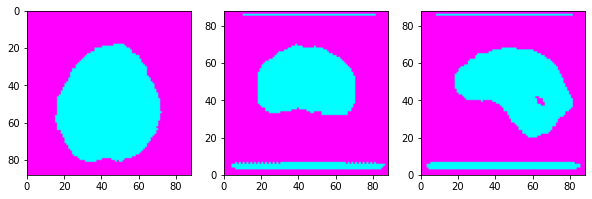

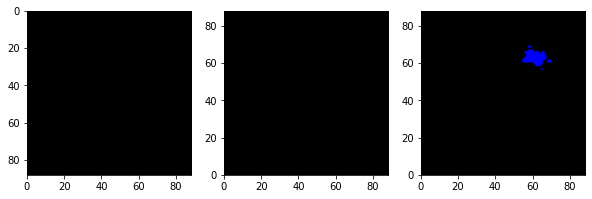

--------------------------------------------------
+ TRAINING 	Epoch: 73 	Loss: 0.891441
+ TRAINING 	Epoch: 74 	Loss: 0.883708
+ TRAINING 	Epoch: 75 	Loss: 0.925080
--------------------------------------------------
+ VALIDATE 	Epoch: 75 	Loss: 0.000001


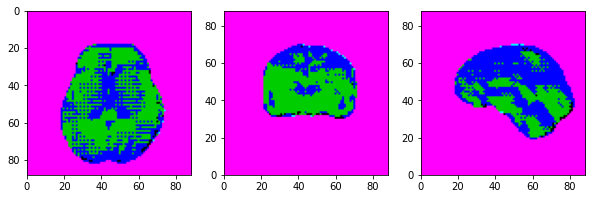

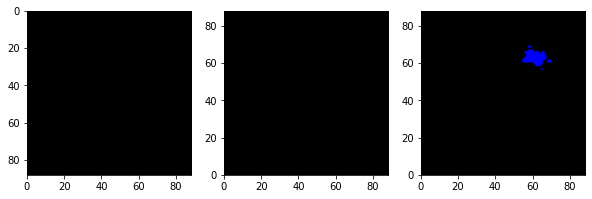

--------------------------------------------------
+ TRAINING 	Epoch: 76 	Loss: 0.868898
+ TRAINING 	Epoch: 77 	Loss: 0.929366
+ TRAINING 	Epoch: 78 	Loss: 0.936421
--------------------------------------------------
+ VALIDATE 	Epoch: 78 	Loss: 0.000001


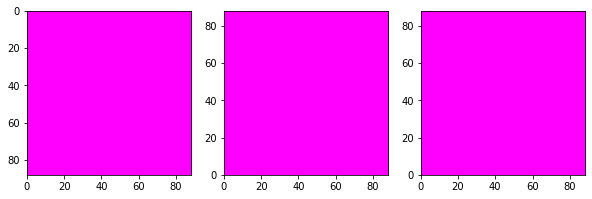

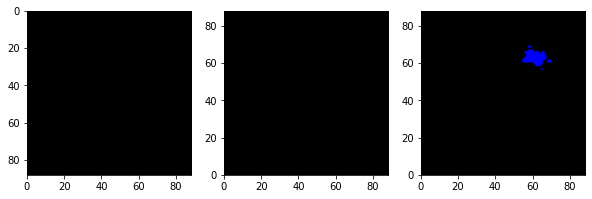

--------------------------------------------------
+ TRAINING 	Epoch: 79 	Loss: 0.886958
+ TRAINING 	Epoch: 80 	Loss: 0.917334
+ TRAINING 	Epoch: 81 	Loss: 0.881874
--------------------------------------------------
+ VALIDATE 	Epoch: 81 	Loss: 0.000001


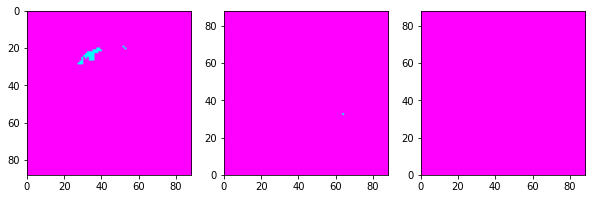

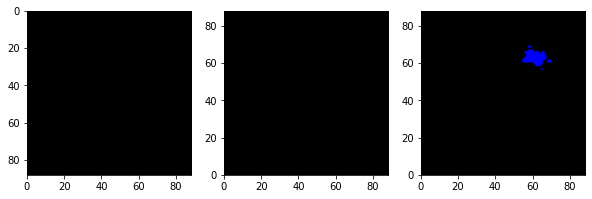

--------------------------------------------------
+ TRAINING 	Epoch: 82 	Loss: 0.954463
+ TRAINING 	Epoch: 83 	Loss: 0.888475
+ TRAINING 	Epoch: 84 	Loss: 0.877376
--------------------------------------------------
+ VALIDATE 	Epoch: 84 	Loss: 0.000001


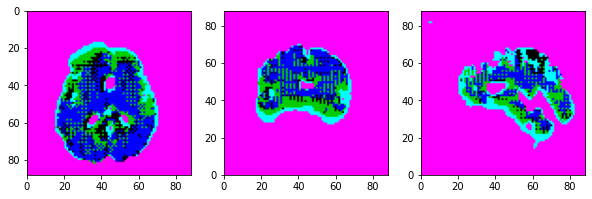

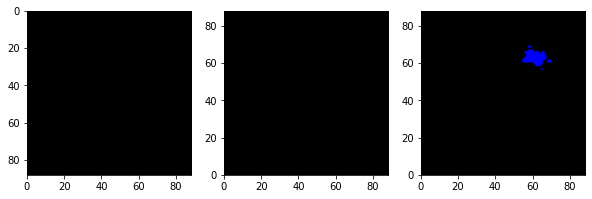

--------------------------------------------------
+ TRAINING 	Epoch: 85 	Loss: 0.862094
+ TRAINING 	Epoch: 86 	Loss: 0.854866
+ TRAINING 	Epoch: 87 	Loss: 0.956436
--------------------------------------------------
+ VALIDATE 	Epoch: 87 	Loss: 0.000001


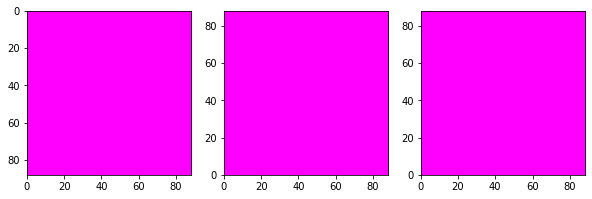

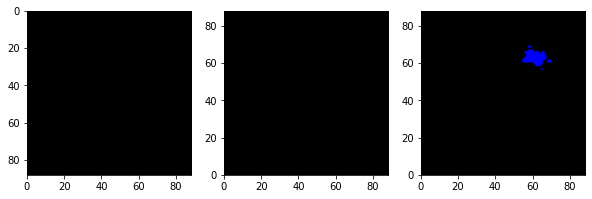

--------------------------------------------------
+ TRAINING 	Epoch: 88 	Loss: 0.898157
+ TRAINING 	Epoch: 89 	Loss: 0.976073
+ TRAINING 	Epoch: 90 	Loss: 0.844245
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.000001


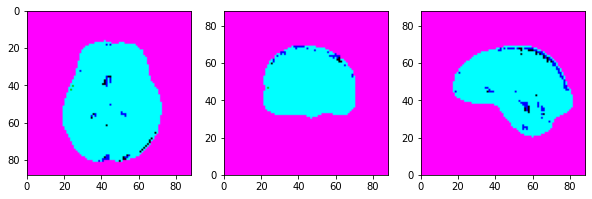

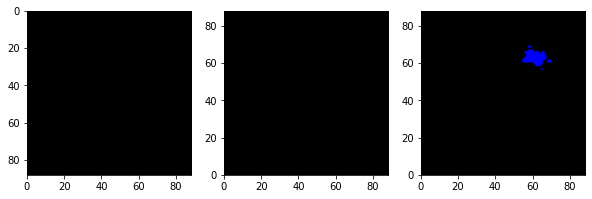

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.884718
+ TRAINING 	Epoch: 92 	Loss: 0.931109
+ TRAINING 	Epoch: 93 	Loss: 0.880751
--------------------------------------------------
+ VALIDATE 	Epoch: 93 	Loss: 0.000001


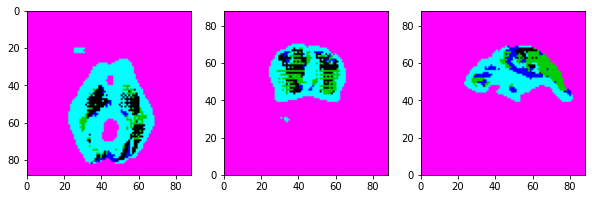

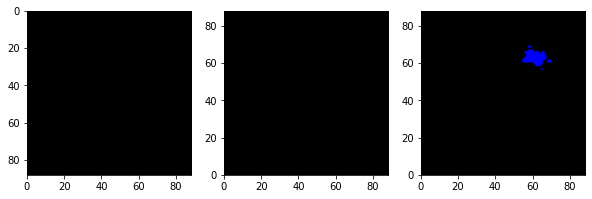

--------------------------------------------------
+ TRAINING 	Epoch: 94 	Loss: 0.974695
+ TRAINING 	Epoch: 95 	Loss: 0.856463
+ TRAINING 	Epoch: 96 	Loss: 0.843583
--------------------------------------------------
+ VALIDATE 	Epoch: 96 	Loss: 0.000001


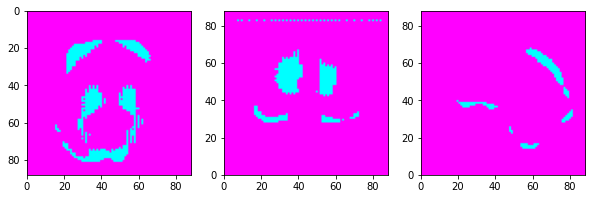

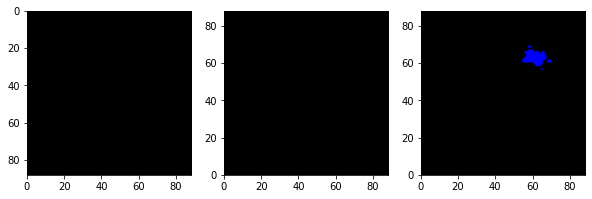

--------------------------------------------------
+ TRAINING 	Epoch: 97 	Loss: 0.844972
+ TRAINING 	Epoch: 98 	Loss: 0.974902
+ TRAINING 	Epoch: 99 	Loss: 0.877473
--------------------------------------------------
+ VALIDATE 	Epoch: 99 	Loss: 0.000001


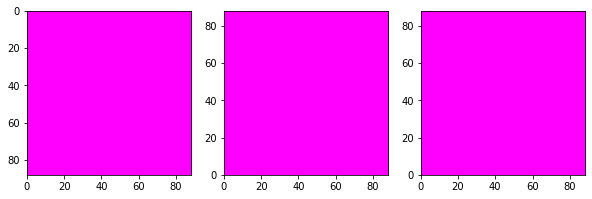

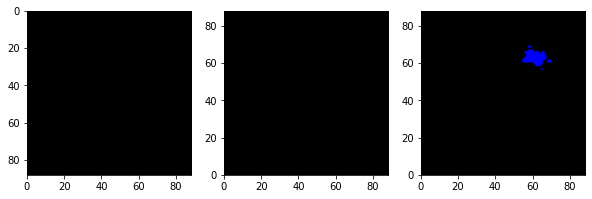

--------------------------------------------------
+ TRAINING 	Epoch: 100 	Loss: 0.832460
+ TRAINING 	Epoch: 101 	Loss: 0.838720
+ TRAINING 	Epoch: 102 	Loss: 0.838850
--------------------------------------------------
+ VALIDATE 	Epoch: 102 	Loss: 0.000001


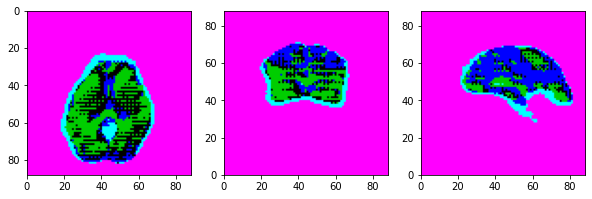

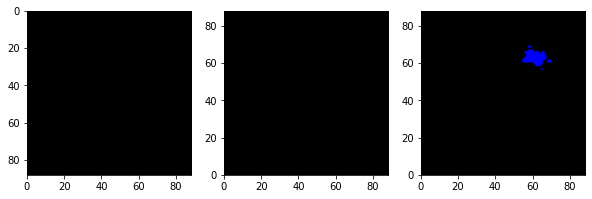

--------------------------------------------------
+ TRAINING 	Epoch: 103 	Loss: 0.849557
+ TRAINING 	Epoch: 104 	Loss: 0.871593
+ TRAINING 	Epoch: 105 	Loss: 0.898880
--------------------------------------------------
+ VALIDATE 	Epoch: 105 	Loss: 0.000001


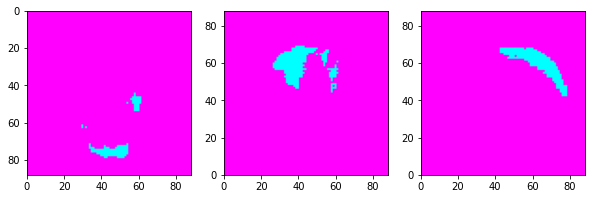

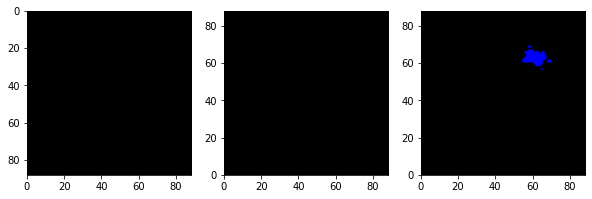

--------------------------------------------------
+ TRAINING 	Epoch: 106 	Loss: 0.853517
+ TRAINING 	Epoch: 107 	Loss: 0.869972
+ TRAINING 	Epoch: 108 	Loss: 0.854569
--------------------------------------------------
+ VALIDATE 	Epoch: 108 	Loss: 0.000001


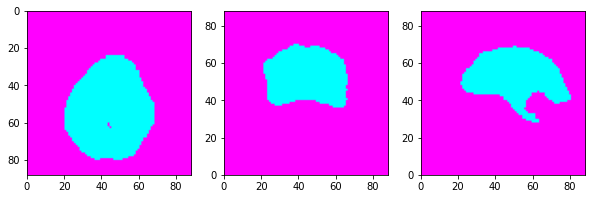

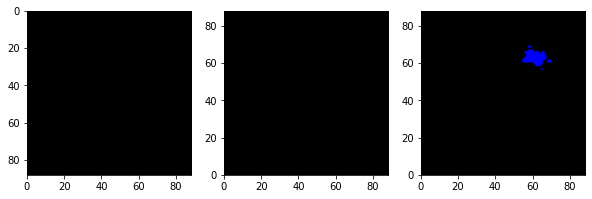

--------------------------------------------------
+ TRAINING 	Epoch: 109 	Loss: 0.852234
+ TRAINING 	Epoch: 110 	Loss: 0.874234
+ TRAINING 	Epoch: 111 	Loss: 0.885050
--------------------------------------------------
+ VALIDATE 	Epoch: 111 	Loss: 0.000001


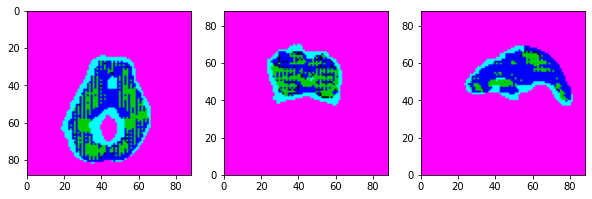

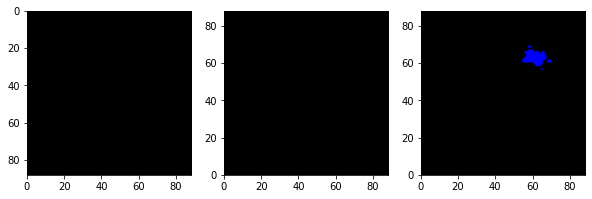

--------------------------------------------------
+ TRAINING 	Epoch: 112 	Loss: 0.811312
+ TRAINING 	Epoch: 113 	Loss: 0.993745
+ TRAINING 	Epoch: 114 	Loss: 0.850301
--------------------------------------------------
+ VALIDATE 	Epoch: 114 	Loss: 0.000001


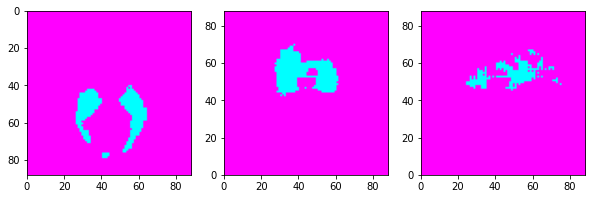

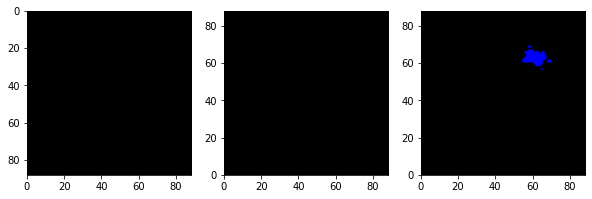

--------------------------------------------------
+ TRAINING 	Epoch: 115 	Loss: 0.895122
+ TRAINING 	Epoch: 116 	Loss: 0.883590
+ TRAINING 	Epoch: 117 	Loss: 0.868843
--------------------------------------------------
+ VALIDATE 	Epoch: 117 	Loss: 0.000001


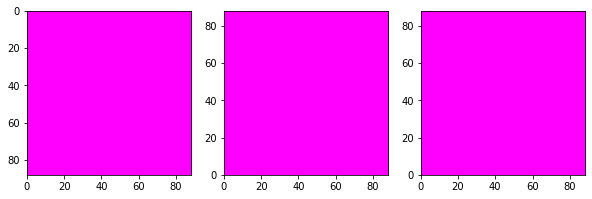

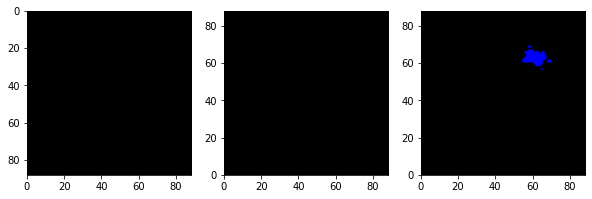

--------------------------------------------------
+ TRAINING 	Epoch: 118 	Loss: 0.792186
+ TRAINING 	Epoch: 119 	Loss: 0.828030
+ TRAINING 	Epoch: 120 	Loss: 0.917846
--------------------------------------------------
+ VALIDATE 	Epoch: 120 	Loss: 0.000001


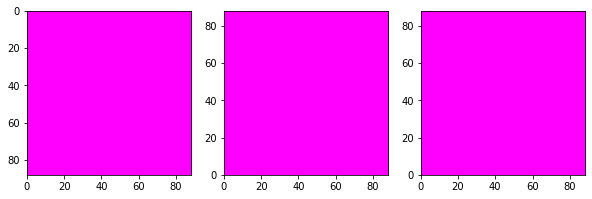

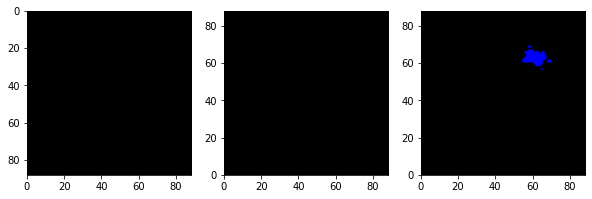

--------------------------------------------------
+ TRAINING 	Epoch: 121 	Loss: 0.780824
+ TRAINING 	Epoch: 122 	Loss: 0.875132
+ TRAINING 	Epoch: 123 	Loss: 0.846453
--------------------------------------------------
+ VALIDATE 	Epoch: 123 	Loss: 0.000001


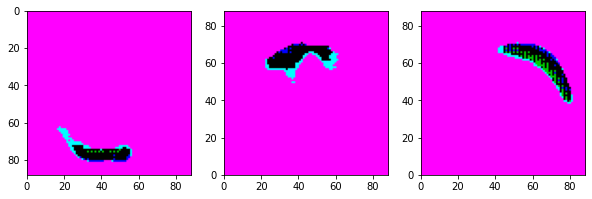

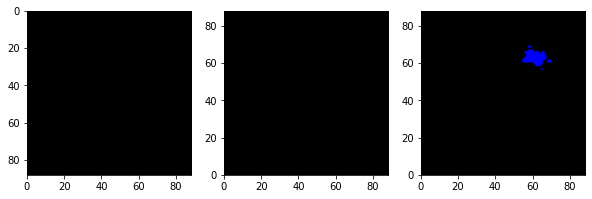

--------------------------------------------------
+ TRAINING 	Epoch: 124 	Loss: 0.847253
+ TRAINING 	Epoch: 125 	Loss: 0.808681
+ TRAINING 	Epoch: 126 	Loss: 0.923294
--------------------------------------------------
+ VALIDATE 	Epoch: 126 	Loss: 0.000001


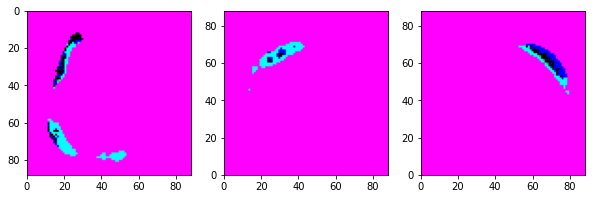

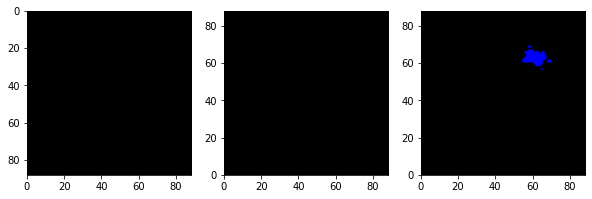

--------------------------------------------------
+ TRAINING 	Epoch: 127 	Loss: 0.789446
+ TRAINING 	Epoch: 128 	Loss: 0.850528
+ TRAINING 	Epoch: 129 	Loss: 0.986059
--------------------------------------------------
+ VALIDATE 	Epoch: 129 	Loss: 0.000001


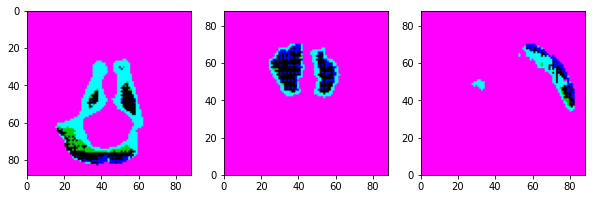

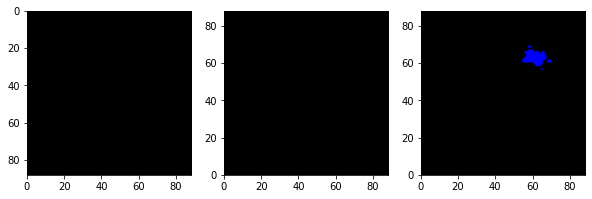

--------------------------------------------------
+ TRAINING 	Epoch: 130 	Loss: 0.822365
+ TRAINING 	Epoch: 131 	Loss: 0.954929
+ TRAINING 	Epoch: 132 	Loss: 0.844404
--------------------------------------------------
+ VALIDATE 	Epoch: 132 	Loss: 0.000001


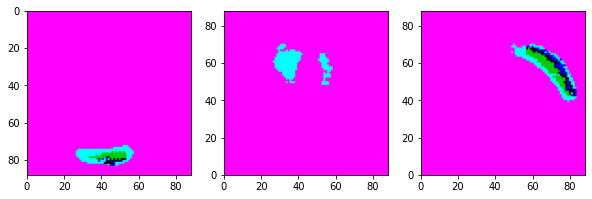

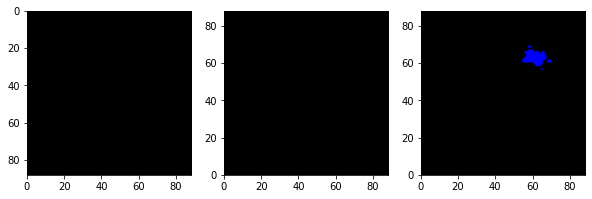

--------------------------------------------------
+ TRAINING 	Epoch: 133 	Loss: 0.835210
+ TRAINING 	Epoch: 134 	Loss: 0.852540
+ TRAINING 	Epoch: 135 	Loss: 0.862400
--------------------------------------------------
+ VALIDATE 	Epoch: 135 	Loss: 0.000001


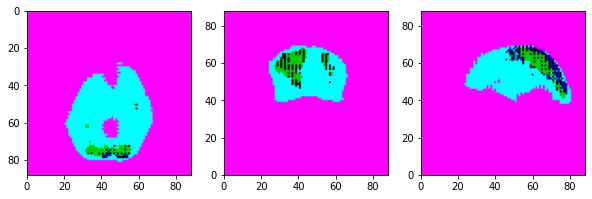

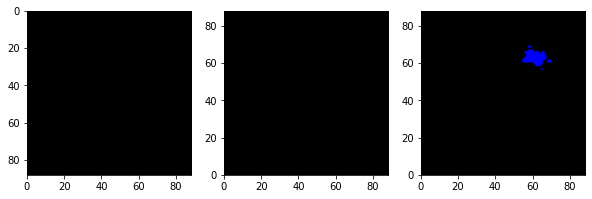

--------------------------------------------------
+ TRAINING 	Epoch: 136 	Loss: 0.921682
+ TRAINING 	Epoch: 137 	Loss: 0.820068
+ TRAINING 	Epoch: 138 	Loss: 0.856235
--------------------------------------------------
+ VALIDATE 	Epoch: 138 	Loss: 0.000001


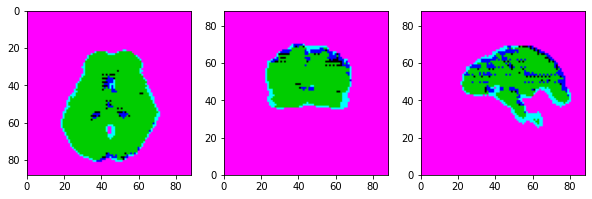

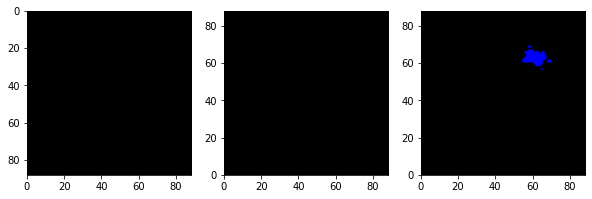

--------------------------------------------------
+ TRAINING 	Epoch: 139 	Loss: 0.878428
+ TRAINING 	Epoch: 140 	Loss: 0.837060
+ TRAINING 	Epoch: 141 	Loss: 0.821848
--------------------------------------------------
+ VALIDATE 	Epoch: 141 	Loss: 0.000001


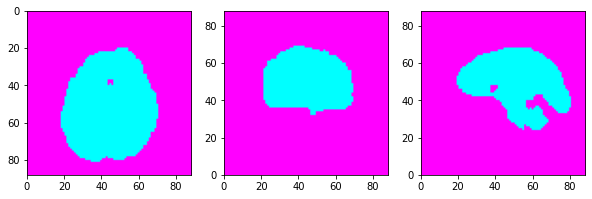

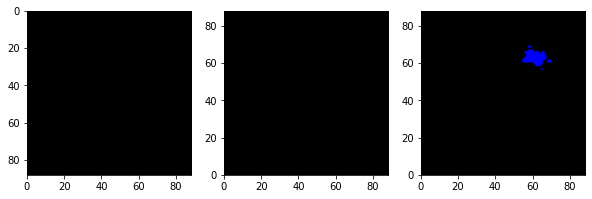

--------------------------------------------------
+ TRAINING 	Epoch: 142 	Loss: 0.871588
+ TRAINING 	Epoch: 143 	Loss: 0.808786
+ TRAINING 	Epoch: 144 	Loss: 0.889045
--------------------------------------------------
+ VALIDATE 	Epoch: 144 	Loss: 0.000001


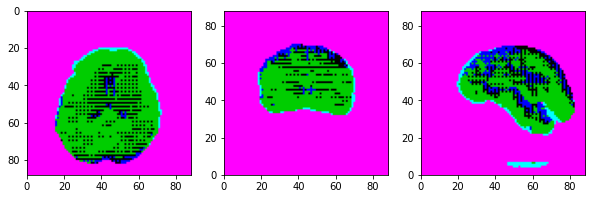

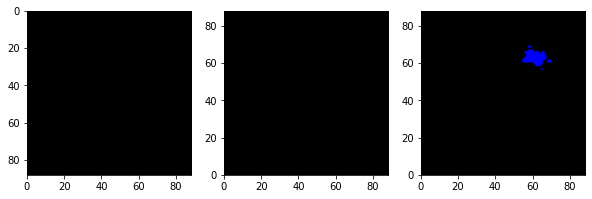

--------------------------------------------------
+ TRAINING 	Epoch: 145 	Loss: 0.847382
+ TRAINING 	Epoch: 146 	Loss: 0.864670
+ TRAINING 	Epoch: 147 	Loss: 0.855608
--------------------------------------------------
+ VALIDATE 	Epoch: 147 	Loss: 0.000001


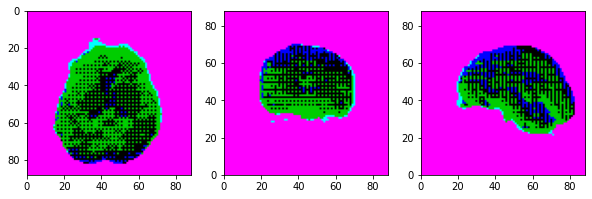

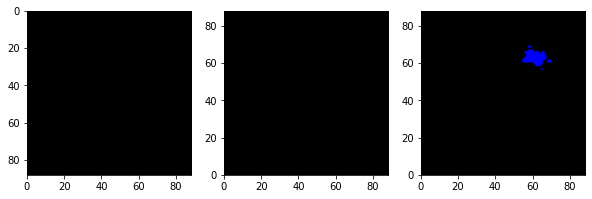

--------------------------------------------------
+ TRAINING 	Epoch: 148 	Loss: 0.857928
+ TRAINING 	Epoch: 149 	Loss: 0.839097
+ TRAINING 	Epoch: 150 	Loss: 0.907609
--------------------------------------------------
+ VALIDATE 	Epoch: 150 	Loss: 0.000001


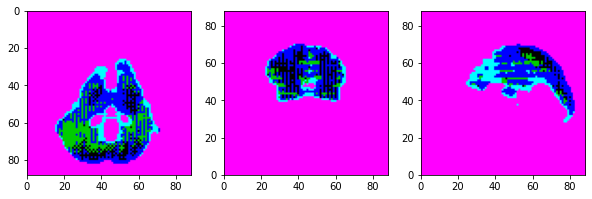

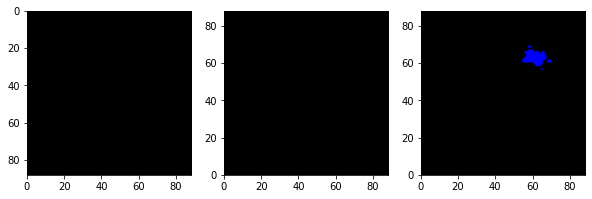

--------------------------------------------------

Finished TRAINING.


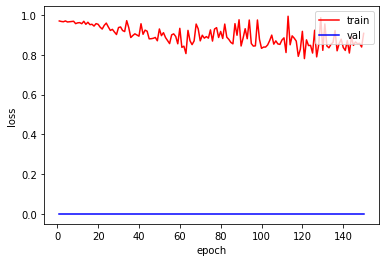

In [66]:
# torch.cuda.empty_cache()

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = Unet(1,32,num_classes)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
model.to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
#         loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        
#         prd_flat = prd.view(seg.size(0), -1).type(torch.FloatTensor)
#         seg_flat = seg.view(seg.size(0), -1).type(torch.FloatTensor)
        intersection = (prd_flat * seg_flat).sum(-1)
        dice_score = 2. * intersection / ((prd_flat + seg_flat).sum(-1) + 1e-5)
        # dice_score = 1 - dice_score.sum() / batch_size
        loss = torch.mean(1. - dice_score)
        
        del img
        del seg
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_train:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
#                 loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                        
#                 prd_flat = prd.view(seg.size(0), -1).type(torch.FloatTensor)
#                 seg_flat = seg.view(seg.size(0), -1).type(torch.FloatTensor)
                intersection = (prd_flat * seg_flat).sum(-1)
                dice_score = 2. * intersection / ((prd_flat + seg_flat).sum(-1) + 1e-5)
                # dice_score = 1 - dice_score.sum() / batch_size
                loss_val += torch.mean(1. - dice_score)
                
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
#         prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy()[0])
#         label = sitk.GetImageFromArray(seg.cpu().squeeze().numpy()[0])
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy())
        label = sitk.GetImageFromArray(seg.cpu().squeeze().numpy())
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        display_image(sitk.LabelToRGB(label))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model2.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
def get_dice_scores(gt, pred, label):
    
    gt = sitk.GetArrayFromImage(gt)
    pred = sitk.GetArrayFromImage(pred)    
    
    gt = gt.flatten()
    pred = pred.flatten()
    TP = len(np.where((gt==label) & (pred==label))[0])
    FP = len(np.where((gt!=label) & (pred==label))[0])
    FN = len(np.where((gt==label) & (pred!=label))[0])

    return 2 * TP / ((2 * TP) + FP + FN)

In [ ]:
model_dir = os.path.join(out_dir, 'segmentation_model')
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = Unet(1,32,4).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model2.pt')))
model.to(device)
model.eval()
    
csf_dice_scores = []
gm_dice_scores  = []


print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        
        csf_dice_scores.append(get_dice_scores(sample['seg'], prediction, 1))
        gm_dice_scores.append(get_dice_scores(sample['seg'], prediction, 2))
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

In [ ]:
####################TEST##########################
fig, axes = plt.subplots(1,3,figsize=(10,4))
fig.tight_layout()
axes[0].title.set_text('csf')
axes[0].boxplot(csf_dice_scores)
axes[1].title.set_text('gm')
axes[1].boxplot(gm_dice_scores)